# Bayesian views on splines

Here, we do some Bayesian stuff with splines based on Simon Wood's [book](https://www.crcpress.com/Generalized-Additive-Models-An-Introduction-with-R-Second-Edition/Wood/p/book/9781498728331) and Cosma Shalizi's [book](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/ADAfaEPoV.pdf).

## Piecewise linear splines

In [46]:
library(greta)
library(gamair)
options(repr.plot.width=6, repr.plot.height=4)

In [7]:
data(engine)

In [8]:
tf.X <- function(x, xj)
{
    tf <- function(x, xj, k) 
    {
        dj <- xj * 0
        dj[j] <- 1
        approx(xj, dj, x)$y
    }
    nk <- length(xj)
    n <- length(x)
    X <- matrix(0, n, nk)
    for (j in seq(nk)) X[,j] <- tf(x, xj, j)
    X
}

In [9]:
size <- engine$size
wear <- engine$wear

In [10]:
sj <- seq(min(size), max(size), length=6)
X <- tf.X(size, sj)
b <- lm(wear ~ X - 1)

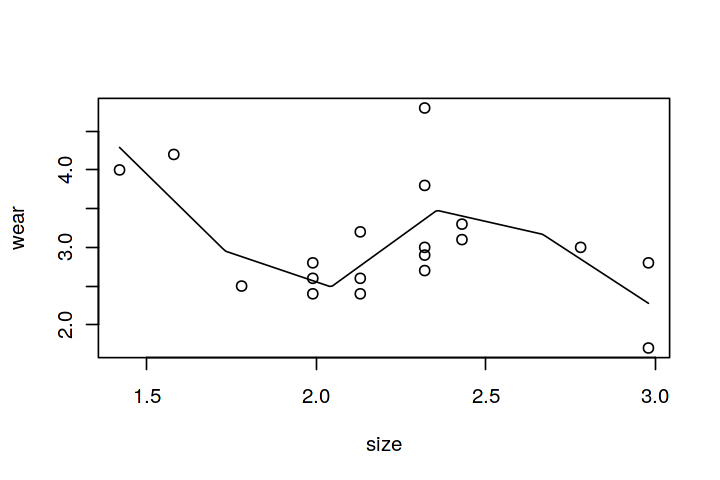

In [11]:
s <- seq(min(size), max(size), length=200)
Xp <- tf.X(s, sj)
plot(size, wear)
lines(s, Xp %*% coef(b))

In [13]:
beta <- greta::normal(0, 10, dim=6)
sd <- greta::uniform(0, 5)
wear <- as_data(wear)
distribution(wear) <- normal(X %*% beta, sd)

In [14]:
m <- model(beta, sd)

In [15]:
samples <- greta::mcmc(m)


running 4 chains simultaneously on up to 4 cores

    warmup ====================================== 1000/1000 | eta:  0s          
  sampling ====================================== 1000/1000 | eta:  0s          


In [16]:
posterior <- as.matrix(samples)[,-7]

In [17]:
head(posterior)

"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[6,1]"
4.491403,2.478112,2.500784,3.864243,3.326645,2.604068
4.679554,2.337177,2.773278,3.352077,2.056679,2.344439
4.844572,3.453564,2.270133,3.417159,2.866596,2.134873
3.606576,3.417487,2.466453,3.366733,3.681352,2.100017
4.129889,2.357038,2.396809,3.631126,2.441314,2.746532
4.638237,2.944872,2.534081,3.218445,2.400328,2.566828


In [18]:
posterior_quants <- apply(as.matrix(samples), 2, quantile, c(.025, .5, .975))
posterior_quants

,"beta[1,1]","beta[2,1]","beta[3,1]","beta[4,1]","beta[5,1]","beta[6,1]",sd
2.5%,3.029097,1.514466,1.693893,2.864643,1.135074,1.328973,0.4553804
50%,4.288008,2.937338,2.498123,3.474678,3.137336,2.260333,0.6456237
97.5%,5.524148,4.384236,3.252361,4.142982,5.087005,3.246643,1.0406446


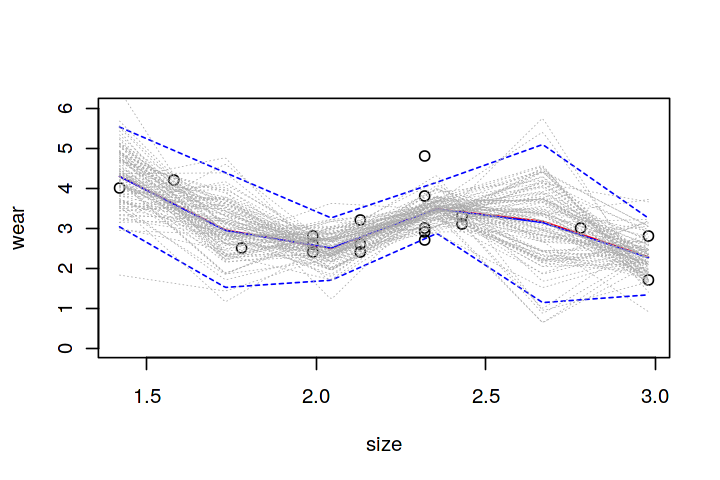

In [20]:
plot(size, wear, ylim=c(0, 6))
lines(s, Xp %*% coef(b), col="red")
lines(s, Xp %*% posterior_quants[1,1:6], col="blue", lty=2)
lines(s, Xp %*% posterior_quants[3,1:6], col="blue", lty=2)
lines(s, Xp %*% posterior_quants[2,1:6], col="blue", lty=1)
for (i in sample(nrow(posterior), 100)) {
    lines(s, Xp %*% posterior[i,], col="darkgrey", lty=3, lwd=.5)
}

### Smoothing

In [23]:
prs.fit <- function(y, x, xj, sp) 
{
    X <- tf.X(x, xj)
    D <- diff(diag(length(xj)))
    X <- rbind(X, sqrt(sp) * D)
    y <- c(y, rep(0, nrow(D)))
    lm(y ~ X - 1)
}

In [37]:
size <- engine$size
wear <- engine$wear
sj <- seq(min(size), max(size), length = 20)
b <- prs.fit(wear, size, sj, 10)

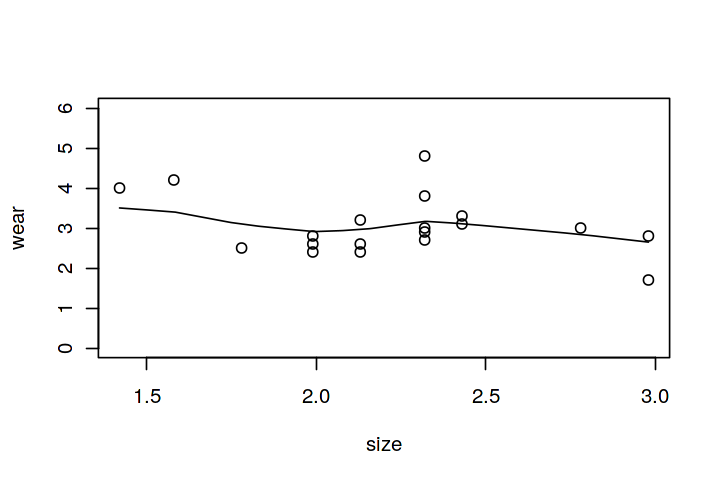

In [38]:
plot(size, wear, ylim=c(0, 6))
Xp <- tf.X(s, sj)
lines(s, Xp %*% coef(b))

In [39]:
rho <- seq(-9, 11, length = 90)
n <- length(wear)
V <- rep(NA, 90)

In [44]:
par(mfrow=c(2, 1))

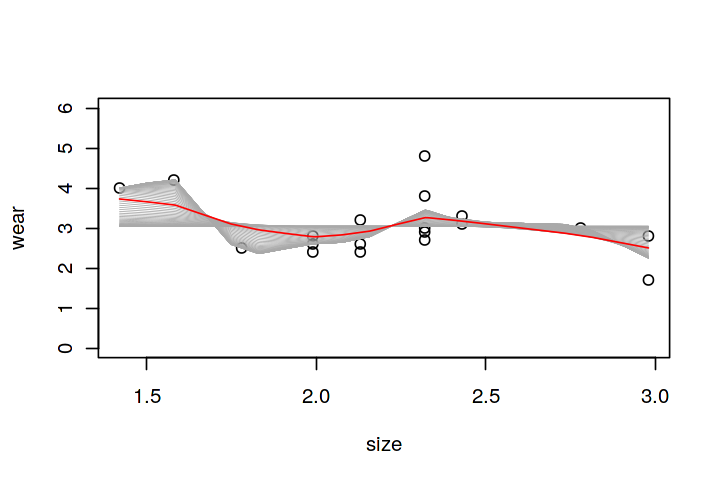

In [52]:
plot(size, wear, ylim=c(0, 6))
for (i in seq(90)) {
    b <- prs.fit(wear, size, sj, exp(rho[i]))
    trF  <- sum(influence(b)$hat[seq(n)])
    rss  <- sum((wear - fitted(b)[seq(n)])^2)
    V[i] <- n * rss  / (n - trF)^2    
    lines(s, Xp %*% coef(b), col="darkgrey", lty=1, lwd=.5)
}
sp <- exp(rho[V == min(V)])
b <- prs.fit(wear, size, sj, sp)
lines(s, Xp %*% coef(b), col="red", lty=1, lwd=1)

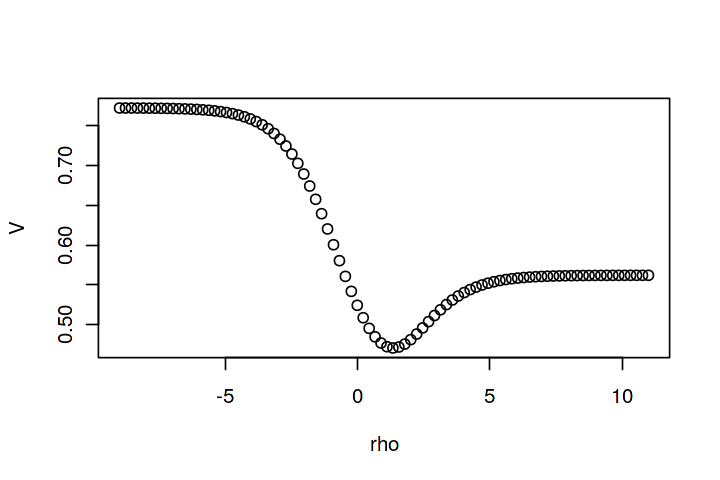

In [53]:
plot(rho, V)

In [57]:
library(lme4)

Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList



In [58]:
llm

ERROR: Error in eval(expr, envir, enclos): object 'llm' not found


here make same with greta, make comparison to hierarchical mdoels and implement this